In [ ]:
%%writefile GAP_Primos.c
#include <stdio.h> 
#include <stdlib.h>
#include <sys/time.h>

float time_diff(struct timeval *start, struct timeval *end){
    return (end->tv_sec - start->tv_sec) + 1e-6*(end->tv_usec - start->tv_usec);
}

int esPrimo(int n){
  int i = 2;
  int bul = 0;
  while(bul == 0 && i < n){
    if(n % i == 0) 
        bul = 1;
        i++;
  }
  return bul;
}

int main(int argc, char **argv){ 

    struct timeval start;
    struct timeval end;
    

  int Diferencia = 0, Primo_Terminante = 2, GAP = 0, i, flag, root = 0;
  gettimeofday(&start, NULL);// <----- tiempo1

  int inicio = 3, fin = atoi(argv[1]);

  int ind;

  for( i = inicio; i <= fin; i++){
    flag = esPrimo(i);   

    if (flag == 0){      
        Diferencia = i - Primo_Terminante;
        if(Diferencia > GAP){
          GAP = Diferencia;                
        }
        //printf("[%d,%d], GAP = %d\n",Primo_Terminante,i,GAP)  ;  
        Primo_Terminante = i;
    }
  }
 
  printf("\nValores en el rango [1,%d]\nMaximo GAP encontrado fue: %d\n",  fin, GAP);

  gettimeofday(&end, NULL); // <----- tiempo2
  printf("Tiempo ejecutado en %f segundos", time_diff(&start, &end));
  return 0;
}

Writing GAP_Primos.c


In [ ]:
%%script bash
echo "GAP Entre Primos"
gcc GAP_Primos.c -o GAP_Primos -lm
./GAP_Primos 100000 >> tiempo_sec.dat 

GAP Entre Primos


In [3]:
%%writefile GAP_Primos_Paralelo_Version1.c
#include "mpi.h"
#include <stdio.h> 
#include <stdlib.h>
#include <sys/time.h>

float time_diff(struct timeval *start, struct timeval *end){
    return (end->tv_sec - start->tv_sec) + 1e-6*(end->tv_usec - start->tv_usec);
}

int esPrimo(int n){
  int i = 2;
  int bul = 0;
  while(bul == 0 && i < n){
    if(n % i == 0) 
        bul = 1;
        i++;
  }
  return bul;
}

#define BLOCK_LOW(id, p, n) ((id) * (n) / (p))
#define BLOCK_HIGH(id, p, n) (BLOCK_LOW((id) + 1, p, n) - 1)
#define BLOCK_SIZE(id, p, n) (BLOCK_HIGH(id, p, n) - BLOCK_LOW(id, p, n) + 1)

int main(int argc, char **argv){
  MPI_Init(&argc, &argv);
  int id, i,  np, n, aux, inicio, fin, num_elems_rango, root = 0, total;
  double t1, t2;

    MPI_Comm_rank(MPI_COMM_WORLD, &id);
    MPI_Comm_size(MPI_COMM_WORLD, &np);

    //struct timeval start;
    //struct timeval end;
  
  t1 = MPI_Wtime(); // <----- tiempo1
  n = atoi(argv[1]);
  inicio = BLOCK_LOW(id, np, n) + 1; // para que empiece en 1    
  fin = BLOCK_HIGH(id, np, n) + 1;
  num_elems_rango = BLOCK_SIZE(id, np, n);
    

  int Diferencia = 0, Primo_Terminante = 2, GAP = 0, flag;
  //gettimeofday(&start, NULL);// <----- tiempo1

  if(id==0) inicio = 3; //fin = atoi(argv[1]);

  int valoracion = 0;
  MPI_Barrier(MPI_COMM_WORLD);
  int ind;

  for( i = inicio; i <= fin; i++){
    flag = esPrimo(i);   

    if (flag == 0){      
        Diferencia = i - Primo_Terminante;
        if(Diferencia > GAP){
          GAP = Diferencia;                
        }
        //printf("[%d,%d], gap = %d\n",Primo_Terminante,i,GAP);  
        Primo_Terminante = i;
    }
  }

  MPI_Send(&valoracion, 1, MPI_INT, root, 9, MPI_COMM_WORLD);

  if(id == root){
    for(i = 0; i < np; i++){
      MPI_Recv(&valoracion, 1, MPI_INT, i, 9, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
      total += valoracion;
    }
     printf("\nValores en el rango [1,%d]\nMaximo GAP encontrado fue: %d\n",  fin, GAP);
     t2 = MPI_Wtime(); // <----- tiempo2
     float tiempo = t2-t1;
     printf("Tiempo ejecutado en: %d procesos y %f segundos \n", np, tiempo);
  }

  //gettimeofday(&end, NULL); // <----- tiempo2
  //printf("Tiempo ejecutado en %f segundos", time_diff(&start, &end));
  MPI_Finalize();
  return 0;
}

Writing GAP_Primos_Paralelo_Version1.c


In [4]:
%%script bash
mpicc GAP_Primos_Paralelo_Version1.c -o GAP_Primos_Paralelo_Version1 -lm
rm tiempos_v1.dat
echo "Contando primos en paralelo v1"
for i in $(seq 1 15)
do
    echo " ----- Usando $i procesos"
    mpirun --allow-run-as-root -np $i GAP_Primos_Paralelo_Version1 100000 >> tiempos_v1.dat    
done

Contando primos en paralelo v1
 ----- Usando 1 procesos
 ----- Usando 2 procesos
 ----- Usando 3 procesos
 ----- Usando 4 procesos
 ----- Usando 5 procesos
 ----- Usando 6 procesos
 ----- Usando 7 procesos
 ----- Usando 8 procesos
 ----- Usando 9 procesos
 ----- Usando 10 procesos
 ----- Usando 11 procesos
 ----- Usando 12 procesos
 ----- Usando 13 procesos
 ----- Usando 14 procesos
 ----- Usando 15 procesos


rm: cannot remove 'tiempos_v1.dat': No such file or directory


In [ ]:
%%writefile GAP_Primos_Paralelo_Version2.c
#include "mpi.h"
#include <stdio.h> 
#include <stdlib.h>
#include <sys/time.h>

float time_diff(struct timeval *start, struct timeval *end){
    return (end->tv_sec - start->tv_sec) + 1e-6*(end->tv_usec - start->tv_usec);
}

int esPrimo(int n){
  int i = 2;
  int bul = 0;
  while(bul == 0 && i < n){
    if(n % i == 0) 
        bul = 1;
        i++;
  }
  return bul;
}

#define BLOCK_LOW(id, p, n) ((id) * (n) / (p))
#define BLOCK_HIGH(id, p, n) (BLOCK_LOW((id) + 1, p, n) - 1)
#define BLOCK_SIZE(id, p, n) (BLOCK_HIGH(id, p, n) - BLOCK_LOW(id, p, n) + 1)

int main(int argc, char **argv){
  MPI_Init(&argc, &argv);
  int id, i,  np, n, aux, inicio, fin, num_elems_rango, root = 0, total, sendbuf, recvbuf;;
  double t1, t2;

    MPI_Comm_rank(MPI_COMM_WORLD, &id);
    MPI_Comm_size(MPI_COMM_WORLD, &np);

    //struct timeval start;
    //struct timeval end;
  
  t1 = MPI_Wtime(); // <----- tiempo1
  n = atoi(argv[1]);
  inicio = BLOCK_LOW(id, np, n) + 1; // para que empiece en 1    
  fin = BLOCK_HIGH(id, np, n) + 1;
  num_elems_rango = BLOCK_SIZE(id, np, n);

  if (np > n/2 && id == root){
    printf("Los Procesos son desmesuradamente... Procure con un número menor\n");
    MPI_Abort(MPI_COMM_WORLD,99);
  }

  int Diferencia = 0, Primo_Terminante = 2, GAP = 0, flag;
  //gettimeofday(&start, NULL);// <----- tiempo1

  if(id==0) inicio = 3; //fin = atoi(argv[1]);

  int valoracion = 0;
  MPI_Barrier(MPI_COMM_WORLD);
  int ind;

  for( i = inicio; i <= fin; i++){
    flag = esPrimo(i);   

    if (flag == 0){      
        Diferencia = i - Primo_Terminante;
        if(Diferencia > GAP){
          GAP = Diferencia;                
        }
        //printf("[%d,%d], gap = %d\n",Primo_Terminante,i,GAP);  
        Primo_Terminante = i;
    }
  }

  MPI_Reduce(&valoracion, &total, 1, MPI_INT, MPI_SUM, root, MPI_COMM_WORLD); 


  if (id == root) {
        total = 0;
        for (i = 0; i < np; i++) {
            total += valoracion;
        }
        printf("\nValores en el rango [1,%d]\nMaximo GAP encontrado fue: %d\n",  fin, GAP);
        t2 = MPI_Wtime(); // <----- tiempo2
        float tiempo = t2-t1;
        printf("Tiempo ejecutado en: %d procesos y %f segundos \n", np, tiempo);
    }

  MPI_Finalize();
  return 0;
}

Overwriting GAP_Primos_Paralelo_Version2.c


In [ ]:
%%script bash
mpicc GAP_Primos_Paralelo_Version2.c -o GAP_Primos_Paralelo_Version2 -lm
rm tiempos_v2.dat
echo "Contando primos en paralelo v2"
for i in $(seq 1 15)
do
    echo " ----- Usando $i procesos"
    mpirun --allow-run-as-root -np $i GAP_Primos_Paralelo_Version2 100000 >> tiempos_v2.dat    
done

Contando primos en paralelo v2
 ----- Usando 1 procesos
 ----- Usando 2 procesos
 ----- Usando 3 procesos
 ----- Usando 4 procesos
 ----- Usando 5 procesos
 ----- Usando 6 procesos
 ----- Usando 7 procesos
 ----- Usando 8 procesos
 ----- Usando 9 procesos
 ----- Usando 10 procesos
 ----- Usando 11 procesos
 ----- Usando 12 procesos
 ----- Usando 13 procesos
 ----- Usando 14 procesos
 ----- Usando 15 procesos


rm: cannot remove 'tiempos_v2.dat': No such file or directory


In [ ]:
%matplotlib inline

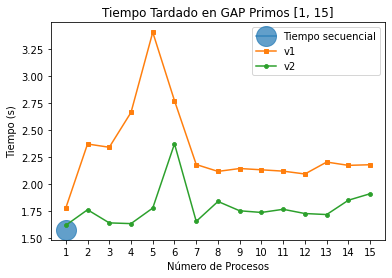

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

tiempo_secuencial = 1.574726

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

tiempos_ms_v1 = np.array([1.777304,2.369657,2.339390,2.661968,3.403403,
                          2.770290,2.179620,2.116046,2.142815,2.130759,
                          2.118393,2.092237,2.202463,2.171919,2.177771])


tiempos_ms_v2 = np.array([1.617494,1.761263,1.639740,1.633075,1.777089,
                          2.371212,1.653750,1.837887,1.751672,1.736344,
                          1.765425,1.726272,1.716894,1.849584,1.909588])

fig, ax = plt.subplots()

ax.plot([1],[tiempo_secuencial],marker ='o',markersize=20,alpha=0.7,label='Tiempo secuencial')
ax.plot(procesos,tiempos_ms_v1,marker = 's',markersize = 4,label="v1")
ax.plot(procesos,tiempos_ms_v2,marker = '8',markersize = 4,label="v2")

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo Tardado en GAP Primos [1, 15]')
plt.legend()
plt.show()

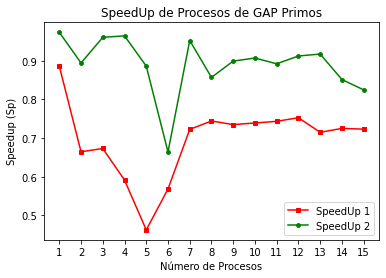

In [ ]:
speedup_ms1 = tiempo_secuencial / tiempos_ms_v1
speedup_ms2 = tiempo_secuencial / tiempos_ms_v2

fig, ax = plt.subplots()

ax.plot(procesos,speedup_ms1,marker='s',label='SpeedUp 1',markersize=4,color='r')
ax.plot(procesos,speedup_ms2,marker='8',label='SpeedUp 2',markersize=4,color='g')


plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup (Sp)')
plt.title('SpeedUp de Procesos de GAP Primos')

plt.legend()
plt.show()

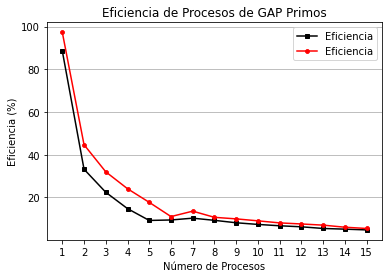

In [ ]:
eficiencia_ms1 = speedup_ms1 / procesos * 100
eficiencia_ms2 = speedup_ms2 / procesos * 100

fig, ax = plt.subplots()

ax.plot(procesos,eficiencia_ms1,marker='s',label='Eficiencia',markersize=4,color='k')
ax.plot(procesos,eficiencia_ms2,marker='8',label='Eficiencia',markersize=4,color='r')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia (%)')
plt.title('Eficiencia de Procesos de GAP Primos')

plt.legend()
plt.show()

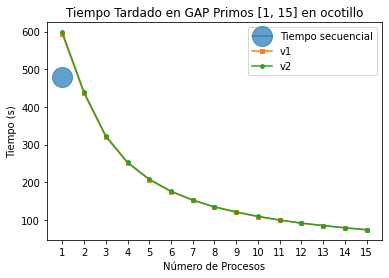

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 478.860291

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

tiempos_ms_v1 = np.array([593.272156,435.929199,320.688629,251.533905,206.894272,
                          175.339188,152.097748,134.275299,120.411041,108.867096,
                          99.473267,91.418121,84.751862,78.826294,73.644287])


tiempos_ms_v2 = np.array([598.280579,439.330322,323.426147,253.137802,208.425430,
                          176.295807,153.102661,135.036407,121.600449,109.612518,
                          100.044579,91.855148,85.315025,79.425598,74.344910])

fig, ax = plt.subplots()

ax.plot([1],[tiempo_secuencial],marker ='o',markersize=20,alpha=0.7,label='Tiempo secuencial')
ax.plot(procesos,tiempos_ms_v1,marker = 's',markersize = 4,label="v1")
ax.plot(procesos,tiempos_ms_v2,marker = '8',markersize = 4,label="v2")

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo Tardado en GAP Primos [1, 15] en ocotillo')
plt.legend()
plt.show()

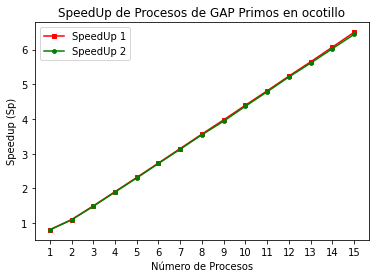

In [ ]:
speedup_ms1 = tiempo_secuencial / tiempos_ms_v1
speedup_ms2 = tiempo_secuencial / tiempos_ms_v2

fig, ax = plt.subplots()

ax.plot(procesos,speedup_ms1,marker='s',label='SpeedUp 1',markersize=4,color='r')
ax.plot(procesos,speedup_ms2,marker='8',label='SpeedUp 2',markersize=4,color='g')


plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup (Sp)')
plt.title('SpeedUp de Procesos de GAP Primos en ocotillo')

plt.legend()
plt.show()

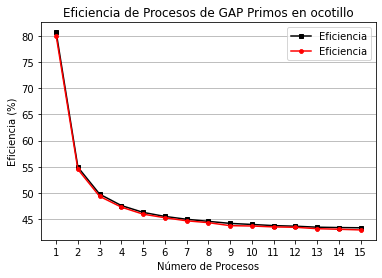

In [ ]:
eficiencia_ms1 = speedup_ms1 / procesos * 100
eficiencia_ms2 = speedup_ms2 / procesos * 100

fig, ax = plt.subplots()

ax.plot(procesos,eficiencia_ms1,marker='s',label='Eficiencia',markersize=4,color='k')
ax.plot(procesos,eficiencia_ms2,marker='8',label='Eficiencia',markersize=4,color='r')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia (%)')
plt.title('Eficiencia de Procesos de GAP Primos en ocotillo')

plt.legend()
plt.show()